In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import boxcox

In [32]:
plt.rcParams['figure.figsize'] = (15, 8)

In [33]:
base_db = pd.read_csv("../output/base_db.csv").drop(columns="Unnamed: 0")

## Matrix factorization

We want to give a score to the tuple (chemicals, specie) and compute the pericolosity of the chemicals on new species based on the score (Netflix prize problem)

In [34]:
X_fact = base_db.copy()
X_fact = X_fact[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]

In [35]:
X_fact["score"] = 1/(X_fact.conc1_mean*X_fact.obs_duration_mean)

In [36]:
X_fact = X_fact.groupby(by=["test_cas", "species"]).agg("median")

In [37]:
X_fact = X_fact.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index()

Standardize the score: apply log(1+x) and scale over (1,5)

In [38]:
X_fact.score = X_fact.score.apply(lambda x: np.log1p(x))

In [39]:
# MinMax scale score
minmax = MinMaxScaler((1, 5))
minmax.fit(X_fact[["score"]])
X_fact[["score"]] = minmax.transform(X_fact[["score"]])

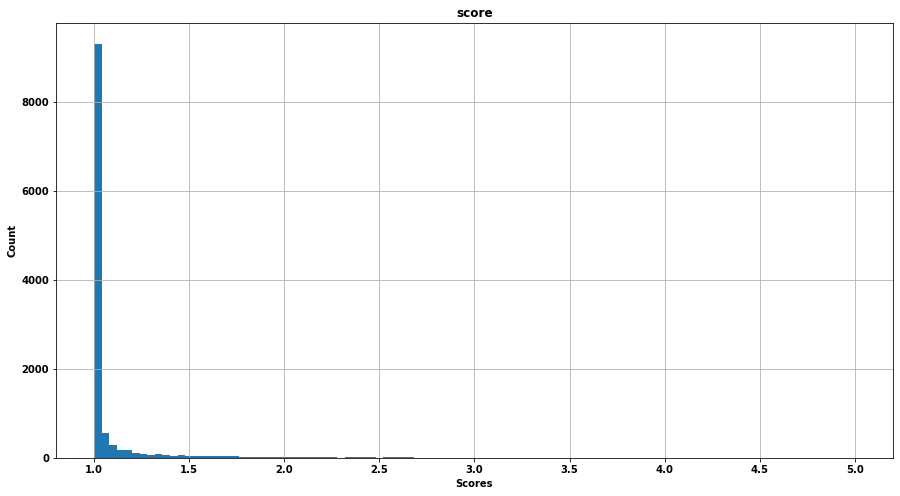

In [40]:
X_fact[["score"]].hist(bins=100);
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Scores")
plt.ylabel("Count");

Dropping the outliers:

In [41]:
X_fact[X_fact.score > 4]

,test_cas,species,score
5139,1397940,spathula,4.783209
5869,2642719,niloticus,5.000000
8459,11118722,spathula,4.755218


In [42]:
X_fact = X_fact.drop(index=[5139, 5869, 8459])

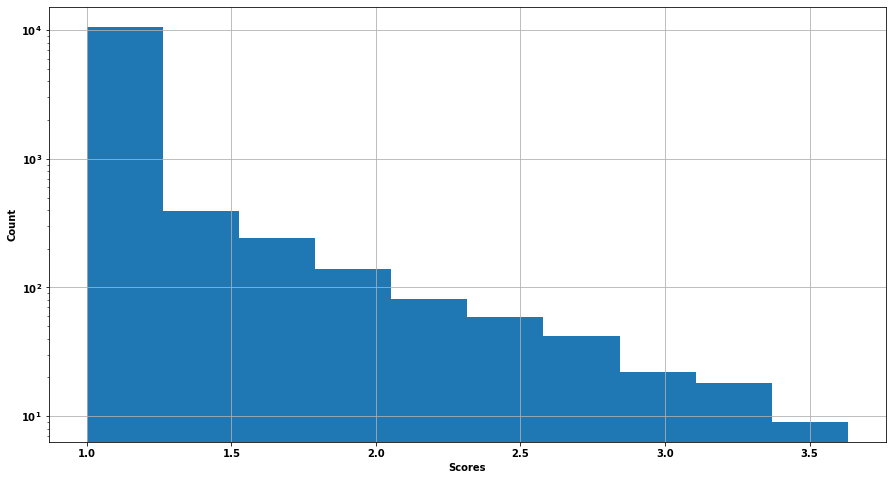

In [43]:
X_fact.score.hist()
plt.yscale('log')
plt.xlabel("Scores")
plt.ylabel("Count");

In [44]:
enc = OrdinalEncoder(dtype=int)
enc.fit(X_fact[["test_cas", "species"]])
X_fact[["test_cas", "species"]] = enc.transform(X_fact[["test_cas", "species"]]) + 1

Output matrix to use with Surprise library:

In [45]:
X_fact.to_csv("../output/score_matrix_nomix.csv", header=True, index=False)

Preparing matrix for lab code:

In [46]:
X_fact["id"] = "r" + X_fact.test_cas.astype("str") + '_' + "c"+ X_fact.species.astype("str")

In [47]:
X_fact = X_fact[["id", "score"]].set_index("id")
X_fact.to_csv("../output/score_matrix.csv", header=True)

#### Another tentative of scoring

In [48]:
X_fact = base_db.copy()
X_fact = X_fact[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]
X_fact["score"] = 1/(X_fact.conc1_mean*X_fact.obs_duration_mean)
X_fact = X_fact.groupby(by=["test_cas", "species"]).agg("median")
X_fact = X_fact.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index()

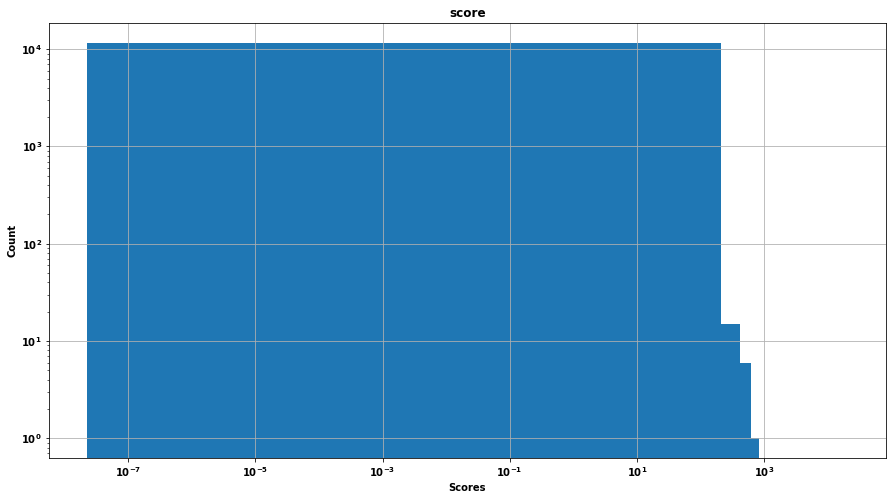

In [49]:
X_fact[["score"]].hist(bins=100);
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Scores")
plt.ylabel("Count");

Giving a score based on the distribution:
- $ < (10^-5)$ -> score 1
- $ >(10^-5)$ and $ <(10^-3)$ -> score 2
- $ >(10^-3)$ and $ <(10^-1)$ -> score 3
- $ >(10^-1)$ and $ <(10^11)$ -> score 4
- $ >(10^1)$ -> score 5

In [50]:
def scores_cat(x):
    if (x <= 10**-5):
        return 1
    elif ((x>10**-5) and (x<=10**-3)):
        return 2
    elif ((x>10**-3) and (x<=10**-1)):
        return 3
    elif ((x>10**-1) and (x<=10**1)):
        return 4
    else:
        return 5

In [51]:
X_fact.score = X_fact.score.apply(lambda x: scores_cat(x))

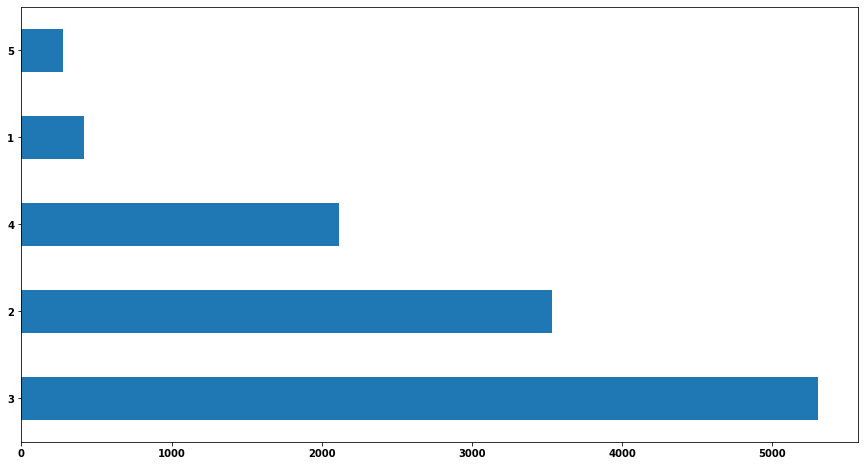

In [52]:
X_fact.score.value_counts().plot(kind="barh");

In [53]:
X_fact.score.value_counts()

3    5306
2    3530
4    2115
1     420
5     279
Name: score, dtype: int64

In [54]:
enc = OrdinalEncoder(dtype=int)
enc.fit(X_fact[["test_cas", "species"]])
X_fact[["test_cas", "species"]] = enc.transform(X_fact[["test_cas", "species"]]) + 1

In [55]:
X_fact.to_csv("../output/score_matrix_cat.csv", header=True, index=False)

# NEW SCORE TENTATIVES

## CONSIDERING ONLY 96 H

In [388]:
X_fact = base_db.copy()
X_fact = X_fact[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]

In [389]:
X_fact = X_fact[X_fact.obs_duration_mean==96]

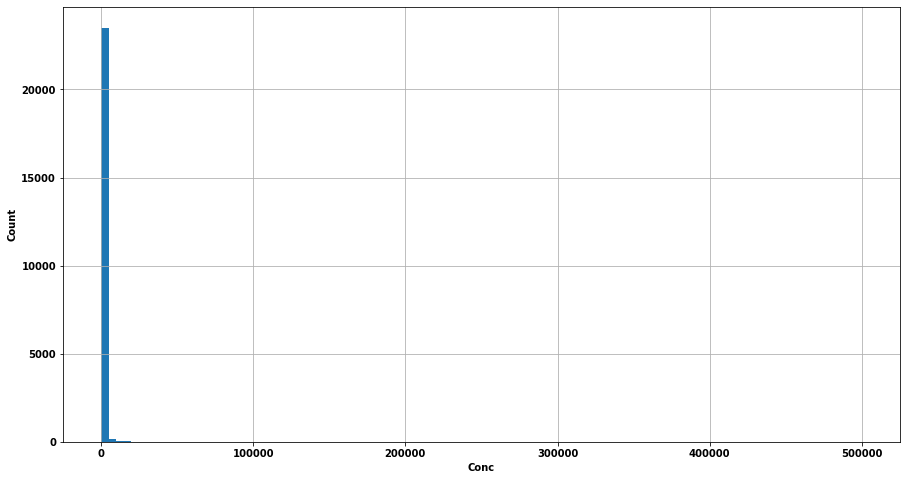

In [390]:
# plotting the distribution of conc inside this case
X_fact.conc1_mean.hist(bins=100)
#plt.yscale('log')
plt.xlabel("Conc")
plt.ylabel("Count");

In [391]:
# # applying coxbox transformation to reduce skewness
# X_fact.conc1_mean, lambda_ = boxcox(X_fact.conc1_mean)
# X_fact.conc1_mean.hist(bins=100)
# #plt.yscale('log')
# plt.xlabel("Conc")
# plt.ylabel("Count");

In [392]:
# function to come back from coxbox
#te = np.exp(np.log(lambda_ * X_fact.conc1_mean + 1) / lambda_)

In [393]:
X_fact["score"] = 1/X_fact.conc1_mean

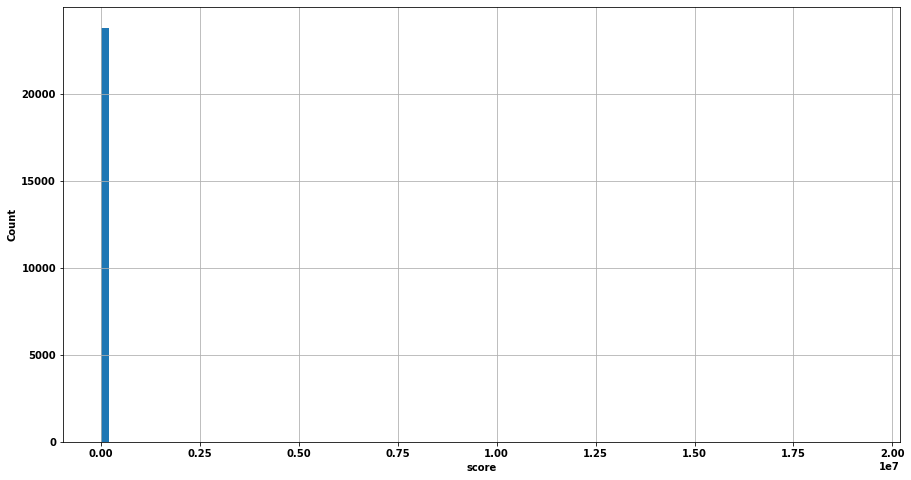

In [394]:
# plotting the distribution of conc inside this case
X_fact.score.hist(bins=100)
#plt.yscale('log')
plt.xlabel("score")
plt.ylabel("Count");

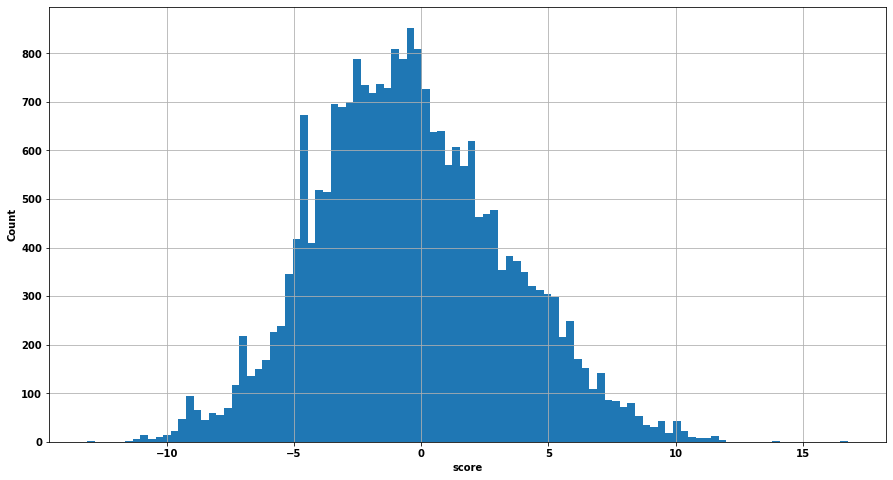

In [395]:
X_fact.score = X_fact.score.apply(lambda x: np.log(x))
# plotting the distribution of conc inside this case
X_fact.score.hist(bins=100)
#plt.yscale('log')
plt.xlabel("score")
plt.ylabel("Count");

In [396]:
# # applying coxbox transformation to reduce skewness
# X_fact.score = boxcox(X_fact.score, lmbda=-1)
# X_fact.score.hist(bins=100)
# #plt.yscale('log')
# plt.xlabel("Conc")
# plt.ylabel("Count");

In [397]:
X_fact = X_fact.groupby(by=["test_cas", "species"]).agg("median")

In [398]:
X_fact = X_fact.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index()

In [399]:
# MinMax scale score
minmax = MinMaxScaler((1, 5))
minmax.fit(X_fact[["score"]])
X_fact[["score"]] = minmax.transform(X_fact[["score"]])

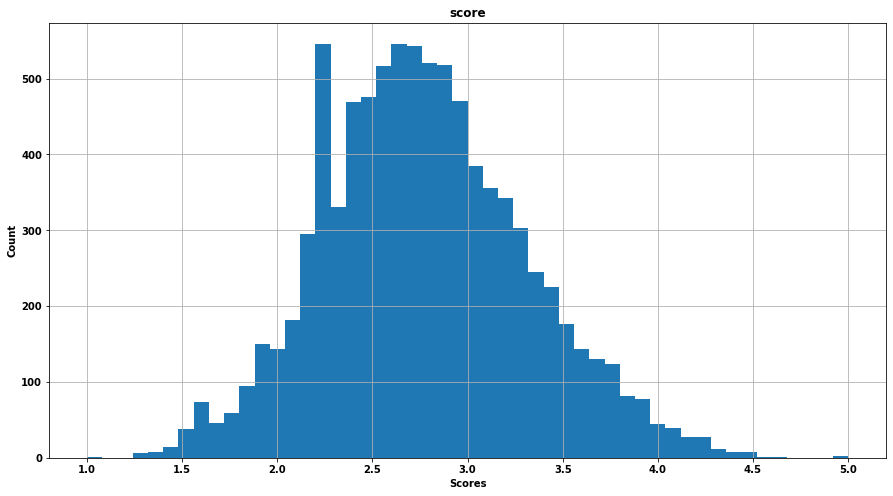

In [400]:
X_fact[["score"]].hist(bins=50);
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Scores")
plt.ylabel("Count");

In [401]:
enc = OrdinalEncoder(dtype=int)
enc.fit(X_fact[["test_cas", "species"]])
X_fact[["test_cas", "species"]] = enc.transform(X_fact[["test_cas", "species"]])

Output matrix to use with Surprise library:

In [319]:
X_fact.to_csv("../output/score_matrix_96h.csv", header=True, index=False)

In [341]:
X_fact

,test_cas,species,score
0,0,3,0.007616
1,0,71,0.013966
2,0,82,0.004310
3,0,131,0.008696
4,0,167,0.009615
...,...,...,...
8795,2577,330,1623.376623
8796,2578,330,892.857143
8797,2579,330,609.384522
8798,2580,331,46.838407


In [321]:
X_res = pd.read_csv("../output/fact3_result.csv").drop(columns="Unnamed: 0").values

In [322]:
X_res

array([[2.34968125, 2.53300576, 2.52021918, ..., 2.79021221, 2.50512689,
        2.45444266],
       [2.61404698, 2.59158814, 2.72631291, ..., 2.95888443, 2.65860301,
        2.63998765],
       [2.51904984, 2.77765905, 2.86601505, ..., 3.00541065, 2.70234913,
        2.65243696],
       ...,
       [2.68753458, 2.71838154, 2.82533315, ..., 2.99089469, 2.7925474 ,
        2.76654885],
       [2.68753458, 2.71838154, 2.82533315, ..., 2.99089469, 2.7925474 ,
        2.76654885],
       [2.68753458, 2.71838154, 2.82533315, ..., 2.99089469, 2.7925474 ,
        2.76654885]])

In [323]:
# total rmse on seen data
from tqdm.notebook import tqdm
dim = X_fact.index.size
s = 0
for _, row in tqdm(X_fact.iterrows()):
    s+=0.5*(row.score - X_res[int(row.test_cas), int(row.species)])**2
rmse = np.sqrt(s/dim)

In [324]:
rmse

0.21713914803033843

In [325]:
# coming back from minmax and coxbox and measure new rmse
X_res2 = minmax.inverse_transform(X_res)
X_res2 = np.exp(X_res2)
#X_res2 = np.exp(np.log(lambda_ * X_res2 + 1) / lambda_)

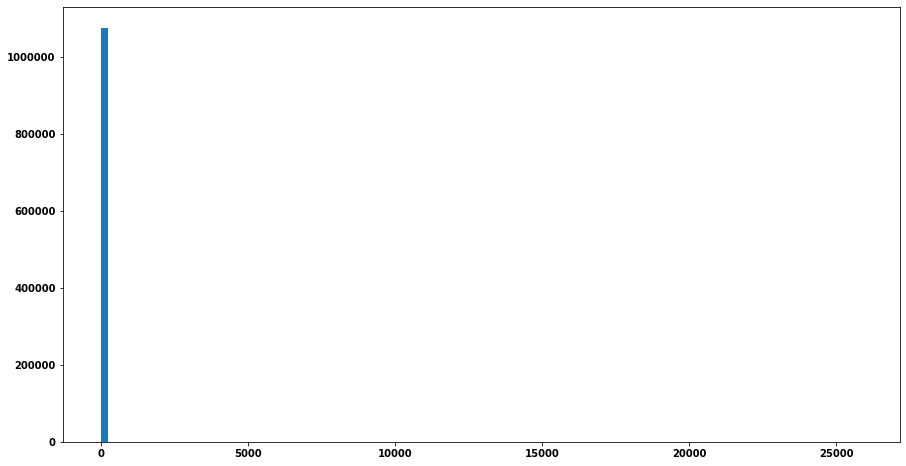

In [326]:
plt.hist(X_res2.flatten(), bins=100);

In [327]:
dim = X_fact.index.size
s = 0
for _, row in tqdm(X_fact.iterrows()):
    s+=0.5*(row.score - X_res2[int(row.test_cas), int(row.species)])**2
rmse2 = np.sqrt(s/dim)

In [328]:
rmse2

309.56883996910557

In [359]:
X_fact

,test_cas,species,score
0,0,3,2.216783
1,0,71,2.307068
2,0,82,2.132026
3,0,131,2.236518
4,0,167,2.251488
...,...,...,...
8795,2577,330,4.043637
8796,2578,330,3.954624
8797,2579,330,3.897751
8798,2580,331,3.515735


In [363]:
test = minmax.inverse_transform(X_fact.score.values.reshape(-1, 1))
test = np.exp(test)
test

array([[7.61614623e-03],
       [1.39664804e-02],
       [4.31034483e-03],
       ...,
       [6.09384522e+02],
       [4.68384075e+01],
       [4.00000000e-04]])

In [375]:
minmax.data_range_

array([26.86530324])

In [371]:
minmax.inverse_transform(np.array([2.97]).reshape(-1, 1))

array([[0.18136916]])

In [367]:
X_res[2579, 330]

2.972560480452114

In [366]:

t = minmax.inverse_transform(X_res[2579, 330].reshape(-1, 1))
#t = np.exp(t)
t

array([[0.19856618]])

In [342]:
X_res2[2579, 330]

1.21965274541905

In [344]:
X_res[2579, 330]

2.972560480452114